<a href="https://colab.research.google.com/github/joestanis/USGS-SAC-25-12553801-DE-RM/blob/main/JoeStanis_USGS_SeismicData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earthquake Data Visualization Tool

## Project Overview

A sample tool built to satisfy the coding exercise for USGS Supervisory Computer Scientist vacancy USGS-SAC-25-12553801-DE-RM. This project is built using specific objectives while emphasizing code efficiency, readability, and adherence to best practices.


## Import the required libraries.

In [1]:
# Import critical modules
import importlib.util

# Install the external ObsPy library if not found. After installation Google Colab might request a restart of the session.
obspy_library = importlib.util.find_spec('obspy')
if obspy_library is None:
    # ObsPy not found so try to install
    !pip install obspy

# Install the external Cartopy library if not found. After installation Google Colab might request a restart of the session.
cartopy_library = importlib.util.find_spec('cartopy')
if cartopy_library is None:
    # Cartopy not found so try to install
    !pip install cartopy

import obspy
from obspy import Stream, Inventory, read_inventory
import cartopy
from IPython.display import display, Markdown
import sqlite3
import datetime


## Initialize the user-defined global variables.

In [2]:
# Array defining paths to each miniSEED file.
mseed_files: list[str] = [
    'https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP01.mseed',
    'https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP02.mseed',
    'https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP03.mseed'
]

# Name of the database where miniSEED data will be stored.
mseed_db_filename: str = 'usgs_miniseed_data.sqlite.db'

# For modularity define the database table names in a dictionary rather than hardcoding them directly into the scripts.
table_names: dict[str, str] = {
    'network_codes': 'network_codes',
    'station_codes': 'station_codes',
    'location_codes': 'location_codes',
    'channel_codes': 'channel_codes',
    'stations': 'stations',
    'mseed_traces': 'mseed_traces',
    'mseed_samples': 'mseed_samples',
    'site_info': 'site_info'
}

# Define the base URL to query IRIS API.
iris_api_url_base = 'https://service.iris.edu/fdsnws/station/1/query'


## Define the utility functions.

### Function to execute a general SQL statement against the database.

In [3]:
def sql_exec(sql: str = ';') -> list:
    """Executes a general SQLite statement.

    :param sql: SQL statement to execute
    :return: List containing the selected data, if any
    """

    try:
        with sqlite3.connect(database=mseed_db_filename) as db_conn:
            db_conn.row_factory = sqlite3.Row
            db_cursor = db_conn.cursor()
            db_cursor.execute(sql)
            db_conn.commit()
            return db_cursor.fetchall()

    except (sqlite3.Error, Exception) as e:
        raise e

    finally:
        db_conn.close()


### Function to insert a single data row into a database table.

In [4]:
def sql_insert(table_name: str = None,
               insert_data: dict[str, any] = None) -> int:
    """Inserts a single data row into a specified table and returns the ID of the last successfully inserted row.

    :param table_name: Table where the data will be inserted
    :param insert_data: Dictionary of name-value pairs, where key is the field name and value is the data to insert
    :return: ID of the inserted row, or 0 if unsuccessful
    """

    if table_name is None:
        raise ValueError('Missing the table name for data insert.')

    if len(insert_data) < 1:
        raise ValueError('Missing {field:value} dictionary to insert.')

    try:
        with sqlite3.connect(database=mseed_db_filename, isolation_level='DEFERRED') as db_conn:
            db_cursor = db_conn.cursor()

            # Extract the field names and values from the data insert dictionary. Extracting one name-value pair at a time to ensure associative integrity.
            row_fields = []
            row_values = []

            for key, val in insert_data.items():
                row_fields.append(f"[{key}]")
                row_values.append(val)

            # Build the insert statement from name-value pairs, telling SQLite to honor any UNIQUE constrains during the insert operation.
            param_placeholders = ','.join('?' * len(row_values))
            sql_query = f"INSERT OR IGNORE INTO [{table_name}] ({','.join(row_fields)}) VALUES ({param_placeholders});"

            db_cursor.execute(sql_query, row_values)
            db_conn.commit()
            if db_cursor.lastrowid:
                return db_cursor.lastrowid
            else:
                # Failed insert can result in last row ID of None, so ensure the function returns an integer.
                return 0

    except (sqlite3.Error, Exception) as e:
        raise e

    finally:
        db_conn.close()


### Function to fast insert multiple data rows into a database table.

In [5]:
def sql_insert_many(table_name: str = None,
                    field_names: list[str] = None,
                    field_values: list[tuple[any]] = None) -> int:
    """Bulk inserts data into a specified table and returns a count of inserted rows.

    :param table_name: Table where the data will be inserted
    :param field_names: List of field names to target for data insertion
    :param field_values: Data to insert into tio table, passed as tuple list items, with data in the same order as the field names
    :return: Count of the inserted rows
    """

    if table_name is None:
        raise ValueError('Missing the table name for data insert.')

    if field_names is None:
        raise ValueError('Missing names of fields for insert.')

    if field_values is None:
        raise ValueError('Missing values to insert for each field.')

    try:
        with sqlite3.connect(database=mseed_db_filename, isolation_level='DEFERRED') as db_conn:
            db_cursor = db_conn.cursor()

            # Build the insert statement from name-value pairs, telling SQLite to honor any UNIQUE constrains during the insert operation.
            param_placeholders = ','.join('?' * len(field_values[0]))
            sql_query = f"INSERT OR IGNORE INTO [{table_name}] ({','.join(field_names)}) VALUES ({param_placeholders});"

            db_cursor.executemany(sql_query, field_values)
            db_conn.commit()
            if db_cursor.lastrowid:
                return db_cursor.lastrowid
            else:
                # Failed insert can result in last row ID of None, so ensure the function returns an integer.
                return 0

    except (sqlite3.Error, Exception) as e:
        raise e

    finally:
        db_conn.close()


### Function to fetch rows from a database table.

In [6]:
def sql_fetch_rows(table_name: str = None,
                   search_values: dict[str:any] = None,
                   return_fields: list[str] = None,
                   limit_rows: int = 0,
                   insert_if_missing: bool = False) -> dict[str, any]:
    """Returns the row data for a provided search values. Optionally attempts to insert row with the search values if none was found.

    :param table_name: Table containing the data to search
    :param search_values: Criteria to use for searching the rows
    :param return_fields: List containing the fields of data to return from the row. If omitted, None, or an empty list then all fields for that row are returned.
    :param limit_rows: List containing the fields of data to return from the row. If omitted, None, or an empty list then all fields for that row are returned.
    :param insert_if_missing: If True, and the provided value is not found, then try to insert a new row with this value
    :return: Dictionary containing the specified row data for the requested search values
    """

    if table_name is None:
        raise ValueError('Missing the table name for data insert.')

    if search_values is None:
        raise ValueError('Missing the search criteria.')

    try:
        select_fields = '*'
        if return_fields is not None:
            select_fields = '[' + '],['.join(return_fields) + ']'

        where_fields = ['1=1']
        for key, val in search_values.items():
            where_fields.append(f"[{key}]='{val}'")

        sql_query = f"SELECT {select_fields} FROM [{table_name}] WHERE {' AND '.join(where_fields)}"
        if limit_rows > 0:
            sql_query += f" LIMIT {limit_rows}"
        sql_query += ';'

        with sqlite3.connect(database=mseed_db_filename) as db_conn:
            db_conn.row_factory = sqlite3.Row
            db_cursor = db_conn.cursor()
            db_cursor.execute(sql_query)
            db_conn.commit()
            result_record = db_cursor.fetchall()

            if result_record:
                # Found a matching row.
                return result_record

            if insert_if_missing:
                # No matching record but attempt to insert a new record and re-fetch.
                sql_last_row_id = sql_insert(table_name=table_name, insert_data=search_values)
                if sql_last_row_id is None:
                    # Failed to insert the new code data
                    return {}

                # Try again to fetch the station location info.
                return sql_fetch_rows(table_name=table_name, search_values=search_values,
                                      return_fields=return_fields, limit_rows=limit_rows)

            # No matching code.
            return {}


    except (sqlite3.Error, Exception) as e:
        raise e

    finally:
        db_conn.close()


### Function to empty a database table.

In [7]:
def sql_truncate_table(table_name: str = None) -> list:
    """Empties all data from a specified table, essentially truncating the table.

    :param table_name: Table to empty of data
    :return: Returns whatever result was received from the call to sql_exec
    """

    if table_name is None:
        raise ValueError('Missing the table name for data insert.')

    try:
        sql_query = f"DELETE FROM [{table_name}];"
        return sql_exec(sql=sql_query)

    except (sqlite3.Error, Exception) as e:
        raise e


### Function to search for a given column value and return the corresponding row ID.

In [8]:
def fields_to_id(table_name: str = None,
                 search_values: dict[str, any] = None,
                 insert_if_missing: bool = False) -> int:
    """Search a table for a specific column value. If found, return the first row ID in the set.

    :param table_name: Table to search
    :param search_values: Dictionary with keys as field names and values as search criteria
    :param insert_if_missing: If True, and the provided value is not found, then try to insert the search data into a new row
    :return: ID of the matching row
    """

    if table_name is None:
        raise ValueError('Missing the table name to search.')

    if search_values is None:
        raise ValueError('Missing the search data to locate the row ID.')

    try:
        sql_result = sql_fetch_rows(table_name=table_name, search_values=search_values, return_fields=['id'],
                                    limit_rows=1, insert_if_missing=insert_if_missing)
        return sql_result[0]['id']

    except (sqlite3.Error, Exception) as e:
        raise e


## Import the miniSEED files into memory.

In [9]:
try:
    # Declare the stream which will hold the consolidation of miniSEED traces from all data sources.
    mseed_stream: obspy.core.Stream = obspy.core.Stream()

    if len(mseed_files) < 1:
        print('Error: No miniSEED files to process.')

    else:
        print(f"Attempting to import data from {len(mseed_files)} miniSEED files.")

        for current_file in mseed_files:
            print(f"Processing '{current_file}'")

            try:
                # Read each miniSEED data source.
                temp_stream = obspy.read(pathname_or_url=current_file)
                print(f"Loaded {len(temp_stream)} traces from the file.")
                mseed_stream += temp_stream

            except IOError:
                print(f"Exception: Unable to open file '{current_file}'.")

        print(f"Imported a total of {len(mseed_stream)} traces from all sources.")

except Exception as e:
    print(f"Exception: {e}")


Attempting to import data from 3 miniSEED files.
Processing 'https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP01.mseed'
Loaded 15 traces from the file.
Processing 'https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP02.mseed'
Loaded 5 traces from the file.
Processing 'https://github.com/CHIGHT-USGS/SeismicData/raw/refs/heads/main/SEP/SEP03.mseed'
Loaded 12 traces from the file.
Imported a total of 32 traces from all sources.


## Provision a database with proper normal form and constraints.

### Create and initialize the code lookup tables.

In [10]:
try:
    # Create the database schema for the NETWORK foreign key table.
    print(f"Creating the [{table_names['network_codes']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['network_codes']}] (
                id INTEGER PRIMARY KEY,
                network_code TEXT NOT NULL, -- A one or two character code identifying the owner of the data
                CONSTRAINT network_code_unique UNIQUE (network_code));"""
    sql_result = sql_exec(sql=sql_query)

    if sql_result is not None:
        # Reset the NETWORK table.
        print(f"Initializing the [{table_names['network_codes']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['network_codes'])

    # Create the database schema for the STATION foreign key table.
    print(f"Creating the [{table_names['station_codes']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['station_codes']}] (
                id INTEGER PRIMARY KEY,
                station_code TEXT NOT NULL, -- A one to five character identifier for the station recording the data
                CONSTRAINT station_code_unique UNIQUE (station_code));"""
    sql_result = sql_exec(sql=sql_query)

    if sql_result is not None:
        # Reset the STATION table.
        print(f"Initializing the [{table_names['station_codes']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['station_codes'])

    # Create the database schema for the LOCATION foreign key table.
    print(f"Creating the [{table_names['location_codes']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['location_codes']}] (
                id INTEGER PRIMARY KEY,
                location_code TEXT NOT NULL, -- A two character code used to uniquely identify different data streams at a single station
                CONSTRAINT location_code_unique UNIQUE (location_code));"""
    sql_result = sql_exec(sql=sql_query)

    if sql_result is not None:
        # Reset the LOCATION table.
        print(f"Initializing the [{table_names['location_codes']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['location_codes'])

    # Create the database schema for the CHANNEL foreign key table.
    print(f"Creating the [{table_names['channel_codes']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['channel_codes']}] (
                id INTEGER PRIMARY KEY,
                channel_code TEXT NOT NULL, -- A three character code identifying the band, instrument type, and sensor orientation
                CONSTRAINT channel_code_unique UNIQUE (channel_code));"""

    sql_result = sql_exec(sql=sql_query)
    if sql_result is not None:
        # Reset the CHANNEL table.
        print(f"Initializing the [{table_names['channel_codes']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['channel_codes'])

except sqlite3.Error as e:
    print(f"Exception: SQLite {' '.join(e.args)}.")

except Exception as e:
    print(f"Exception: {e}")


Creating the [network_codes] table
Initializing the [network_codes] table.
Creating the [station_codes] table
Initializing the [station_codes] table.
Creating the [location_codes] table
Initializing the [location_codes] table.
Creating the [channel_codes] table
Initializing the [channel_codes] table.


### Create and initialize the table to contain metadata about each trace set.

In [11]:
try:
    # Create the database schema for the TRACES table.
    print(f"Creating the [{table_names['mseed_traces']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['mseed_traces']}] (
                id INTEGER PRIMARY KEY,
                network_id INTEGER NOT NULL, -- Foreign key to NETWORK.id
                station_id INTEGER NOT NULL, -- Foreign key to STATION.id
                location_id INTEGER NOT NULL, -- Foreign key to LOCATION.id
                channel_id INTEGER NOT NULL, -- Foreign key to CHANNEL.id
                starttime REAL, -- Unix timestamp UTC
                endtime REAL, -- Unix timestamp UTC
                sampling_rate REAL, -- Rate of samples captured, in Hz
                delta REAL, -- Time increment between data points
                npts INTEGER, -- Number of sampling points in the trace
                calib REAL, -- Trace calibration
                site_info_id INTEGER NOT NULL, -- Foreign key to SITE_INFO.id
                FOREIGN KEY (network_id) REFERENCES {table_names['network_codes']}(id),
                FOREIGN KEY (station_id) REFERENCES {table_names['station_codes']}(id),
                FOREIGN KEY (location_id) REFERENCES {table_names['location_codes']}(id),
                FOREIGN KEY (channel_id) REFERENCES {table_names['channel_codes']}(id)
                FOREIGN KEY (site_info_id) REFERENCES {table_names['site_info']}(id));"""
    sql_result = sql_exec(sql=sql_query)

    if sql_result is not None:
        # Reset the TRACES table.
        print(f"Initializing the [{table_names['mseed_traces']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['mseed_traces'])

except sqlite3.Error as e:
    print(f"Exception: SQLite {' '.join(e.args)}.")

except Exception as e:
    print(f"Exception: {e}")


Creating the [mseed_traces] table
Initializing the [mseed_traces] table.


### Create and initialize the table for holding the miniSEED samples data.

In [12]:
try:
    # Create the database schema for the SAMPLES table.
    print(f"Creating the [{table_names['mseed_samples']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['mseed_samples']}] (
                id INTEGER PRIMARY KEY,
                trace_id INTEGER, -- Foreign key to TRACES.id
                sequence_num INTEGER, -- Sequence number of the individual sample
                sample_value INTEGER, -- Value of the individual sample
                FOREIGN KEY (trace_id) REFERENCES {table_names['mseed_traces']}(id));"""
    sql_result = sql_exec(sql=sql_query)

    if sql_result is not None:
        # Reset the SAMPLES table.
        print(f"Initializing the [{table_names['mseed_samples']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['mseed_samples'])

except sqlite3.Error as e:
    print(f"Exception: SQLite {' '.join(e.args)}.")

except Exception as e:
    print(f"Exception: {e}")


Creating the [mseed_samples] table
Initializing the [mseed_samples] table.


### Create and initialize the table for holding information about the trace sites.

In [13]:
try:
    # Create the database schema for the SITE_INFO table containing metadata about each target site (network + station).
    print(f"Creating the [{table_names['site_info']}] table")
    sql_query = f"""CREATE TABLE IF NOT EXISTS [{table_names['site_info']}] (
                id INTEGER PRIMARY KEY,
                network_id INTEGER NOT NULL, -- Foreign key to NETWORK.id
                station_id INTEGER NOT NULL, -- Foreign key to STATION.id
                latitude REAL, -- Decimal degrees of the site East-West location
                longitude REAL, -- Decimal degrees of the site North-South location
                site_name TEXT, -- Descriptive name for the site
                CONSTRAINT site_info_unique UNIQUE (network_id, station_id),
                FOREIGN KEY (network_id) REFERENCES {table_names['network_codes']}(id),
                FOREIGN KEY (station_id) REFERENCES {table_names['station_codes']}(id));"""
    sql_result = sql_exec(sql=sql_query)
    if sql_result is not None:
        # Reset the STATION table.
        print(f"Initializing the [{table_names['site_info']}] table.")
        sql_result = sql_truncate_table(table_name=table_names['site_info'])

except sqlite3.Error as e:
    print(f"Exception: SQLite {' '.join(e.args)}.")

except Exception as e:
    print(f"Exception: {e}")


Creating the [site_info] table
Initializing the [site_info] table.


## Import the miniSEED data into the newly created database.

In [14]:
try:
    if len(mseed_stream) < 1:
        print('Error: no miniSEED traces to import.')
    else:

        for counter_traces, current_trace in enumerate(mseed_stream, start=1):
            print(
                f"Importing trace {counter_traces} of {len(mseed_stream)} into the [{table_names['mseed_traces']}] table.")

            network_id = fields_to_id(table_name=table_names['network_codes'],
                                      search_values={'network_code': current_trace.stats.network},
                                      insert_if_missing=True)
            if network_id is None:
                # Failed to fetch the required ID, skip to the next trace.
                continue

            station_id = fields_to_id(table_name=table_names['station_codes'],
                                      search_values={'station_code': current_trace.stats.station},
                                      insert_if_missing=True)
            if station_id is None:
                # Failed to fetch the required ID, skip to the next trace.
                continue

            location_id = fields_to_id(table_name=table_names['location_codes'],
                                       search_values={'location_code': current_trace.stats.location},
                                       insert_if_missing=True)
            if location_id is None:
                # Failed to fetch the required ID, skip to the next trace.
                continue

            channel_id = fields_to_id(table_name=table_names['channel_codes'],
                                      search_values={'channel_code': current_trace.stats.channel},
                                      insert_if_missing=True)
            if channel_id is None:
                # Failed to fetch the required ID, skip to the next trace.
                continue

            site_info_id = fields_to_id(table_name=table_names['site_info'],
                                        search_values={'network_id': network_id, 'station_id': station_id},
                                        insert_if_missing=True)
            if site_info_id is None:
                # Failed to fetch the required ID, skip to the next trace.
                continue

            trace_data = {
                'network_id': network_id,
                'station_id': station_id,
                'location_id': location_id,
                'channel_id': channel_id,
                'starttime': current_trace.stats.starttime.timestamp,
                'endtime': current_trace.stats.endtime.timestamp,
                'sampling_rate': current_trace.stats.sampling_rate,
                'delta': current_trace.stats.delta,
                'npts': current_trace.stats.npts,
                'calib': current_trace.stats.calib,
                'site_info_id': site_info_id
            }

            trace_id_last_insert = sql_insert(table_name=table_names['mseed_traces'], insert_data=trace_data)
            counter_traces += 1

            if trace_id_last_insert:
                # Positive row ID, implying a successful insert, so proceed with loading the associated trace samples.
                print(
                    f"Importing {len(current_trace.data)} samples into the [{table_names['mseed_samples']}] table.")

                samples_field_names = [
                    'trace_id',
                    'sequence_num',
                    'sample_value'
                ]

            # Build the samples data for bulk import.
            samples_data = []
            samples_list = current_trace.data.tolist()
            counter_samples = 0
            for current_sample in samples_list:
                samples_data.append((trace_id_last_insert, counter_samples, current_sample))

            # For improved performance use sql_insert_many to bulk import the sample data points rather than importing one at a time using sql_insert.
            sql_insert_many(table_name=table_names['mseed_samples'], field_names=samples_field_names,
                            field_values=samples_data)

except sqlite3.Error as e:
    print(f"Exception: SQLite {' '.join(e.args)}.")

except Exception as e:
    print(f"Exception: {e}")


Importing trace 1 of 32 into the [mseed_traces] table.
Importing 221810 samples into the [mseed_samples] table.
Importing trace 2 of 32 into the [mseed_traces] table.
Importing 380100 samples into the [mseed_samples] table.
Importing trace 3 of 32 into the [mseed_traces] table.
Importing 107800 samples into the [mseed_samples] table.
Importing trace 4 of 32 into the [mseed_traces] table.
Importing 2300 samples into the [mseed_samples] table.
Importing trace 5 of 32 into the [mseed_traces] table.
Importing 87700 samples into the [mseed_samples] table.
Importing trace 6 of 32 into the [mseed_traces] table.
Importing 80700 samples into the [mseed_samples] table.
Importing trace 7 of 32 into the [mseed_traces] table.
Importing 100 samples into the [mseed_samples] table.
Importing trace 8 of 32 into the [mseed_traces] table.
Importing 100 samples into the [mseed_samples] table.
Importing trace 9 of 32 into the [mseed_traces] table.
Importing 100 samples into the [mseed_samples] table.
Impor

## Retrieve location data for each site which provided sample data.

### Query the IRIS API to fetch inventory for each site which provided miniSEED samples.

In [15]:
try:
    # Extract the list of network codes and station codes to separate lists.
    network_codes_list = []
    station_codes_list = []
    for current_trace in mseed_stream.traces:
        if current_trace.stats.network not in network_codes_list:
            network_codes_list.append(current_trace.stats.network)
        if current_trace.stats.station not in station_codes_list:
            station_codes_list.append(current_trace.stats.station)


    api_url = f"{iris_api_url_base}?format=xml&network={','.join(network_codes_list)}&station={','.join(station_codes_list)}"
    print('Fetching inventory data from the IRIS API.')
    site_inventory_samples: obspy.Inventory = read_inventory(api_url)
    print(site_inventory_samples)

except Exception as e:
    print(f"Exception: {e}")


Fetching inventory data from the IRIS API.
Inventory created at 2025-01-02T17:08:30.593200Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    https://service.iris.edu/fdsnws/station/1/query?format=xml&network=...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			CC
		Stations (1):
			CC.SEP (September lobe, Mt. St. Helens (Dome sta))
		Channels (0):



### Query the IRIS API to fetch inventory of HOA and SUG (stations of interest).

In [16]:
try:
    api_url = f"{iris_api_url_base}?format=xml&station=HOA,SUG"
    print('Fetching inventory data from the IRIS API.')
    site_inventory_new: obspy.Inventory = read_inventory(api_url)
    print(site_inventory_new)

except Exception as e:
    print(f"Exception: {e}")


Fetching inventory data from the IRIS API.
Inventory created at 2025-01-02T17:08:31.066100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    https://service.iris.edu/fdsnws/station/1/query?format=xml&station=...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (3):
			CC, SY, UW
		Stations (5):
			CC.HOA (Hoala)
			CC.SUG (Sugar Bowl)
			SY.HOA (HOA synthetic)
			SY.SUG (SUG synthetic)
			UW.SUG (Sugar Bowl)
		Channels (0):



### Consolidate the inventory into a single object and update the database.

In [17]:
try:
    # Merge the inventory objects together.
    site_inventory_merged: obspy.Inventory = site_inventory_samples.copy()
    site_inventory_merged.extend(site_inventory_new.copy())

    print('Updating site information in the database.')
    # Add missing codes to the network code table in the database.
    for current_network in site_inventory_merged.networks:
        network_id = fields_to_id(table_name=table_names['network_codes'],
                                  search_values={'network_code': current_network.code}, insert_if_missing=True)

        # Add missing codes to the station code table in the database.
        for current_station in current_network.stations:
            station_id = fields_to_id(table_name=table_names['station_codes'],
                                      search_values={'station_code': current_station.code}, insert_if_missing=True)

            # Update the site info in the database.
            site_id = fields_to_id(table_name=table_names['site_info'],
                                   search_values={'network_id': network_id, 'station_id': station_id},
                                   insert_if_missing=True)

            try:
                sql_query = f"""UPDATE [{table_names['site_info']}] SET
                                [latitude] = {current_station.latitude},
                                [longitude] = {current_station.longitude},
                                [site_name] = '{current_station.site.name}'
                                WHERE [id] = {site_id};"""

                with sqlite3.connect(database=mseed_db_filename) as db_conn:
                    db_cursor = db_conn.cursor()
                    db_cursor.execute(sql_query)
                    db_conn.commit()

            except sqlite3.Error as e:
                print(f"Exception: SQLite {' '.join(e.args)}.")

            finally:
                db_conn.close()

except Exception as e:
    print(f"Exception: {e}")


Updating site information in the database.


## Create a visualization for the data.

### Prepare miniSEED metadata.

In [18]:
try:
    # Consolidate the traces to build all metadata.
    temp_stream = mseed_stream.copy()
    temp_stream.merge()
    mseed_metadata = temp_stream.traces[0].stats
    print(temp_stream)

except Exception as e:
    print(f"Exception: {e}")

1 Trace(s) in Stream:
CC.SEP.--.EHZ | 2023-11-11T00:00:00.000001Z - 2023-11-26T00:00:00.000001Z | 100.0 Hz, 129600001 samples (masked)


### Collect traces into sets grouped by day.

In [19]:
try:
    traces_grouped: dict[str, list] = {}

    print('Grouping all traces collected the same day into sets.')
    for current_trace in mseed_stream:
        # Use the Day of Year as an index to group traces.
        day_of_year = current_trace.stats.starttime.timetuple().tm_yday
        traces_grouped.setdefault(day_of_year, []).append(current_trace.copy())

    sorted_traces_grouped = dict(sorted(traces_grouped.items()))

    # Merge each set of grouped traces into a single stream.
    streams_grouped: list[obspy.core.Stream] = []
    for current_group in sorted_traces_grouped.values():
        temp_stream = obspy.core.Stream(current_group)
        streams_grouped.append(temp_stream)

except Exception as e:
    print(f"Exception: {e}")


Grouping all traces collected the same day into sets.


### Create a visualization unifying the metadata, data plots, and location map.

# Earthquake Data Visualization Tool

## *MiniSEED Metadata*

sampling_rate: 100.0
delta: 0.01
starttime: 2023-11-11T00:00:00.000001Z
endtime: 2023-11-26T00:00:00.000001Z
npts: 129600001
calib: 1.0
network: CC
station: SEP
location: --
channel: EHZ
mseed: AttribDict({'dataquality': 'D', 'number_of_records': 68, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 4096, 'filesize': 9957376})
_format: MSEED


## *Helicorder Plots*

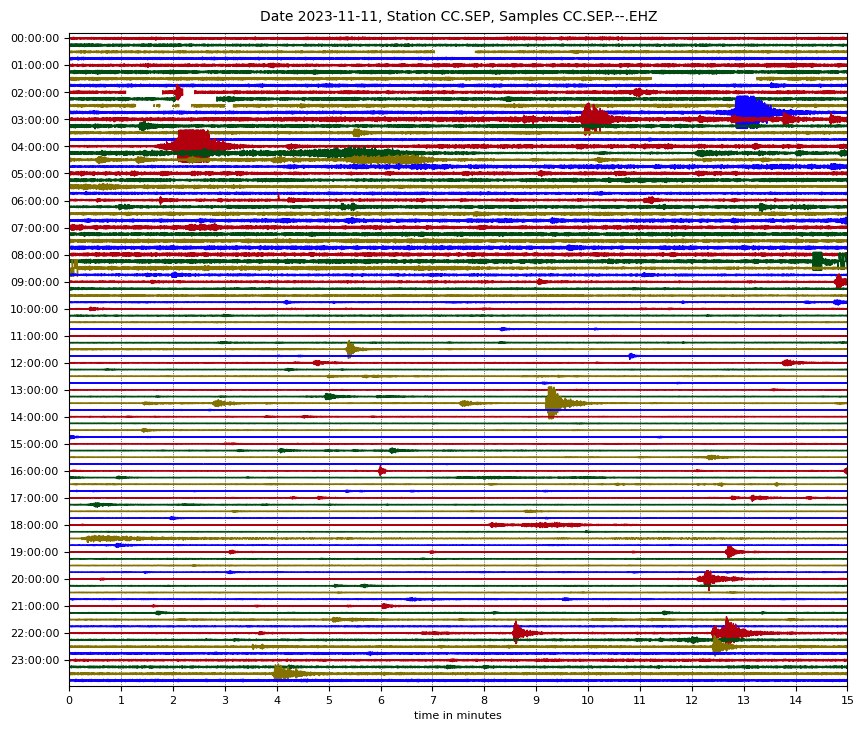

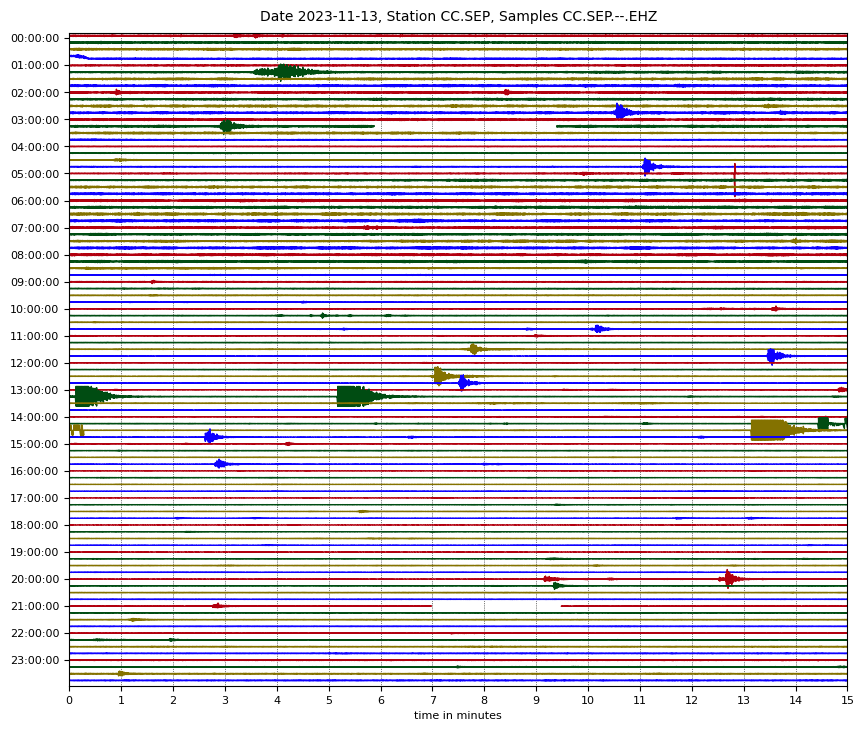

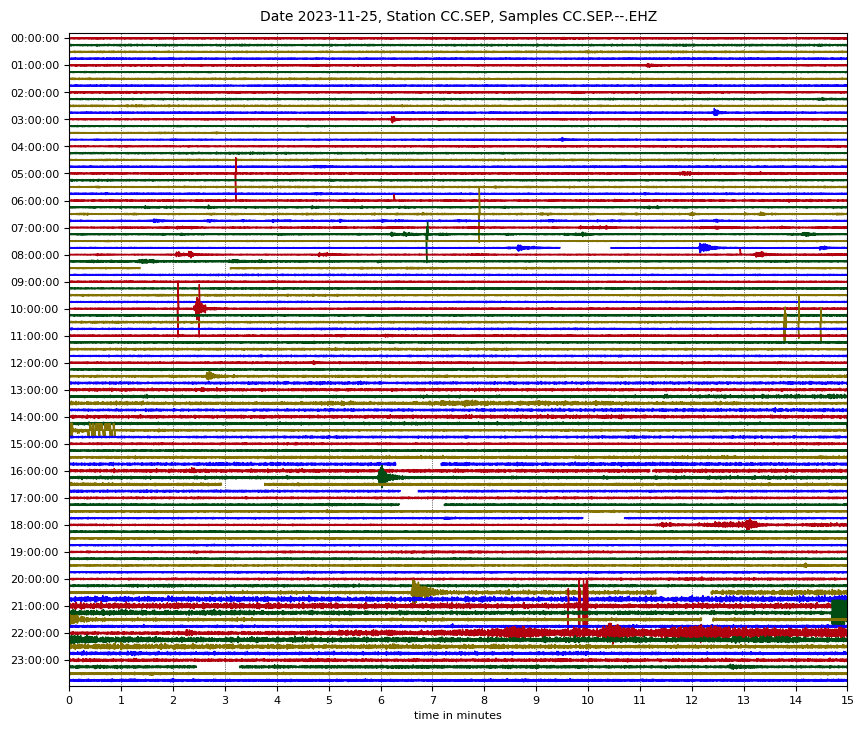

## *Station Locations*

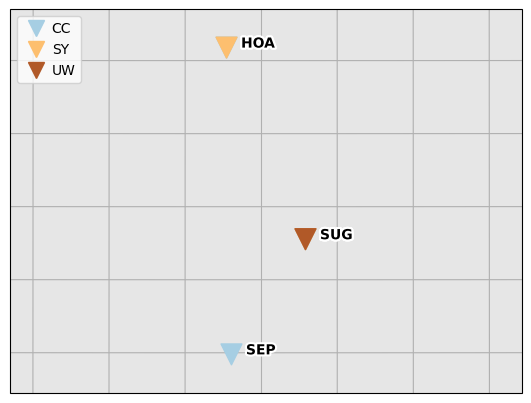

In [21]:
try:
    display(Markdown('# Earthquake Data Visualization Tool'))

    # Render the metadata information.
    display(Markdown('## *MiniSEED Metadata*'))
    for k,v in mseed_metadata.items():
            print(f"{k}: {v}")

    # Render helicorder plots for each day.
    display(Markdown('## *Helicorder Plots*'))
    for temp_stream in streams_grouped:
        plot_date = temp_stream[0].stats.starttime.strftime("%Y-%m-%d")
        plot_station = f"{temp_stream[0].stats.network}.{temp_stream[0].stats.station}"
        plot_id = temp_stream[0].id
        plot_title = f"Date {plot_date}, Station {plot_station}, Samples {plot_id}"
        temp_stream.plot(type='dayplot', show_y_UTC_label=False, title=plot_title, size=(1024, 768))

    # Render a map showing the station locations.
    display(Markdown('## *Station Locations*'))
    site_inventory_merged.plot(projection='local', label=True, color_per_network=True, resolution='i', method='cartopy')

except Exception as e:
    print(f"Exception: {e}")
